In [26]:
import numpy as np
import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt

In [3]:
from torchsummary import summary

In [4]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [5]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [41]:
def train_my_net(net, criterion, optimizer, num_epochs):
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0
      running_loss_test = 0.0
      running_items_test = 0.0
      running_right = 0.0
      running_right_test = 0.0

      net.train()
      for i, data in enumerate(train_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Обнуляем градиент
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)
          running_right += (labels == torch.max(outputs, 1)[1]).sum()

      running_right = running_right.item()
      print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / (i + 1):.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
      acc = running_right / running_items
      train_acc.append(acc)
      # print(type(acc), acc, train_acc)
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

      net.eval()
      with torch.no_grad():
        for i, data in enumerate(valid_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss_test += loss.item()
            running_items_test += len(labels)
            running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

        running_right_test = running_right_test.item()
        print(f'Loss_test: {running_loss_test / (i + 1):.3f}. ' \
              f'Acc_test: {running_right_test / running_items_test:.3f}')
        test_acc.append(running_right_test / running_items_test)
        running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

  print('Training is finished!')

  return train_acc, test_acc

In [7]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


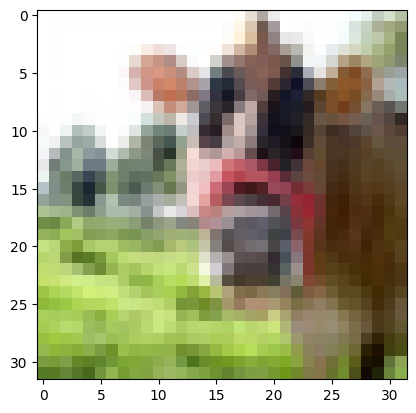

In [8]:
plt.imshow(dataset[0][0])

In [9]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

In [10]:
train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=1)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 64, 3)
        self.bn_two = torch.nn.BatchNorm2d(64)
        self.conv_two = torch.nn.Conv2d(64, 128, 3)
        self.bn_three = torch.nn.BatchNorm2d(128)
        self.conv_three = torch.nn.Conv2d(128, 256, 3)
        self.bn_four = torch.nn.BatchNorm2d(256)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)

    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net().to(device)

In [14]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 30, 30]           1,792
       BatchNorm2d-3           [-1, 64, 15, 15]             128
            Conv2d-4          [-1, 128, 13, 13]          73,856
       BatchNorm2d-5            [-1, 128, 6, 6]             256
            Conv2d-6            [-1, 256, 4, 4]         295,168
       BatchNorm2d-7            [-1, 256, 2, 2]             512
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 100]          25,700
Total params: 1,053,546
Trainable params: 1,053,546
Non-trainable params: 0
---------------------------

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [16]:
%%time
train_acc, test_acc = train_my_net(net, criterion, optimizer, num_epochs=10)

Epoch [1/10]. Loss_train: 4.391. Acc: 0.036. Loss_test: 4.164. Acc_test: 0.060
Epoch [2/10]. Loss_train: 4.080. Acc: 0.067. Loss_test: 4.009. Acc_test: 0.078
Epoch [3/10]. Loss_train: 3.923. Acc: 0.088. Loss_test: 4.062. Acc_test: 0.088
Epoch [4/10]. Loss_train: 3.824. Acc: 0.104. Loss_test: 4.353. Acc_test: 0.064
Epoch [5/10]. Loss_train: 3.744. Acc: 0.115. Loss_test: 4.085. Acc_test: 0.093
Epoch [6/10]. Loss_train: 3.650. Acc: 0.134. Loss_test: 4.337. Acc_test: 0.077
Epoch [7/10]. Loss_train: 3.581. Acc: 0.143. Loss_test: 4.167. Acc_test: 0.100
Epoch [8/10]. Loss_train: 3.517. Acc: 0.158. Loss_test: 4.043. Acc_test: 0.100
Epoch [9/10]. Loss_train: 3.438. Acc: 0.171. Loss_test: 3.757. Acc_test: 0.137
Epoch [10/10]. Loss_train: 3.353. Acc: 0.184. Loss_test: 3.795. Acc_test: 0.133
Training is finished!
CPU times: user 22 s, sys: 2.91 s, total: 24.9 s
Wall time: 2min 16s


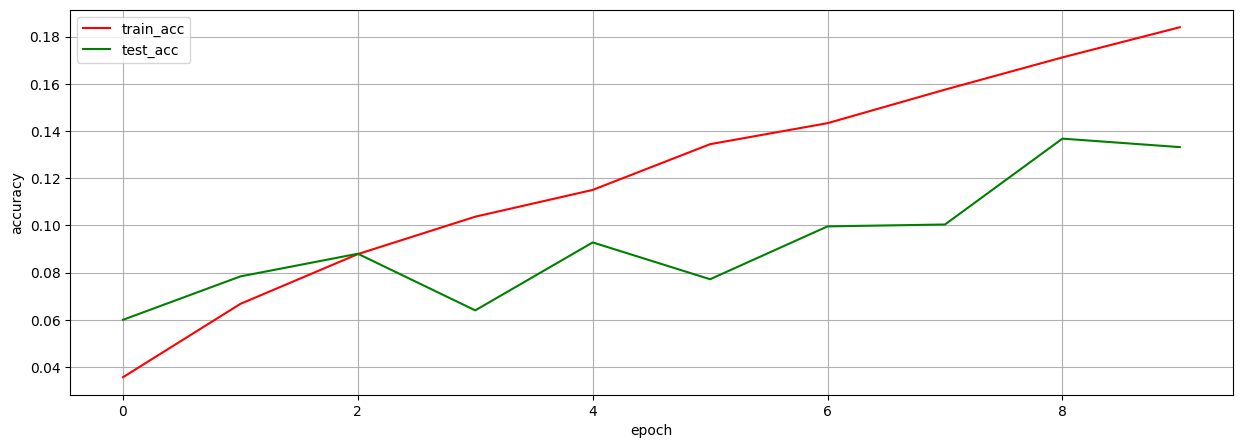

In [17]:
def plot_accuracy(train_acc, test_acc):
  plt.figure(figsize=(15,5))
  plt.plot(train_acc, 'r-', label='train_acc')
  plt.plot(test_acc, 'g-', label='test_acc')
  plt.grid()
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(train_acc, test_acc)

In [22]:
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30)
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.out = torch.nn.Linear(200, 100)



    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = F.relu(x)
        return self.out(x)

In [23]:
net2 = Net2().to(device)

In [24]:
%%time
train_acc, test_acc = train_my_net(net2, criterion, optimizer, num_epochs=10)

Epoch [1/10]. Loss_train: 4.641. Acc: 0.010. Loss_test: 4.609. Acc_test: 0.013
Epoch [2/10]. Loss_train: 4.643. Acc: 0.010. Loss_test: 4.625. Acc_test: 0.013
Epoch [3/10]. Loss_train: 4.643. Acc: 0.010. Loss_test: 4.635. Acc_test: 0.014
Epoch [4/10]. Loss_train: 4.641. Acc: 0.010. Loss_test: 4.636. Acc_test: 0.014
Epoch [5/10]. Loss_train: 4.642. Acc: 0.010. Loss_test: 4.636. Acc_test: 0.014
Epoch [6/10]. Loss_train: 4.641. Acc: 0.010. Loss_test: 4.636. Acc_test: 0.014
Epoch [7/10]. Loss_train: 4.642. Acc: 0.010. Loss_test: 4.636. Acc_test: 0.014
Epoch [8/10]. Loss_train: 4.642. Acc: 0.010. Loss_test: 4.637. Acc_test: 0.014
Epoch [9/10]. Loss_train: 4.642. Acc: 0.010. Loss_test: 4.637. Acc_test: 0.014
Epoch [10/10]. Loss_train: 4.642. Acc: 0.010. Loss_test: 4.636. Acc_test: 0.014
Training is finished!
CPU times: user 14.1 s, sys: 2.8 s, total: 16.9 s
Wall time: 2min 9s


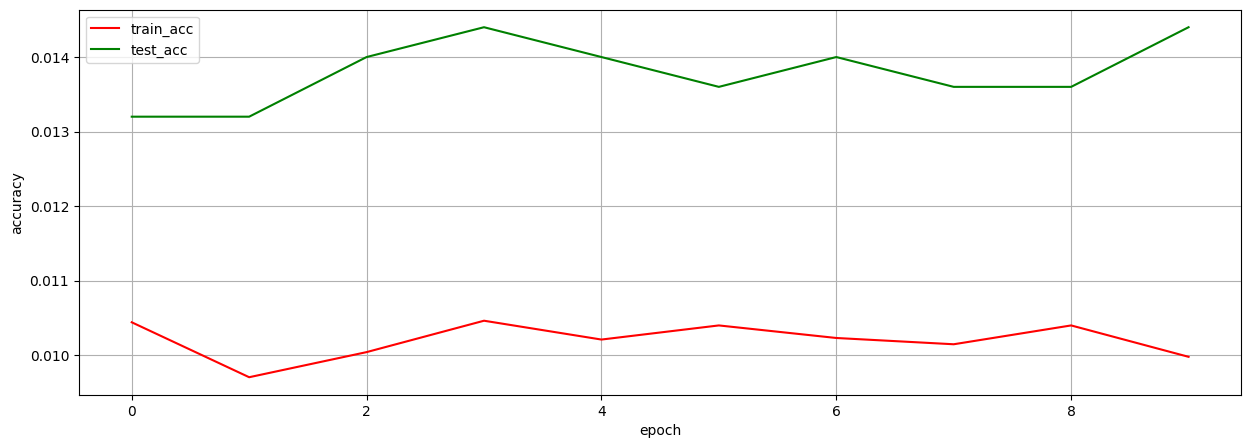

In [25]:
plot_accuracy(train_acc, test_acc)

## ResNet

In [31]:
model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)

In [32]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [33]:
set_parameter_requires_grad(model, True)

In [34]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 100)
)

model.fc = model.fc.to(device)

In [35]:
summary(model, (3, 32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [36]:
train_trans_actions = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

test_trans_actions = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

In [37]:
train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, test_trans_actions)

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=256,
                          shuffle=False,
                          num_workers=1)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [51]:
train_acc, test_acc = train_my_net(model, criterion, optimizer, num_epochs=20)

Epoch [1/20]. Loss_train: 3.374. Acc: 0.209. Loss_test: 3.104. Acc_test: 0.254
Epoch [2/20]. Loss_train: 3.308. Acc: 0.223. Loss_test: 3.078. Acc_test: 0.264
Epoch [3/20]. Loss_train: 3.285. Acc: 0.225. Loss_test: 3.053. Acc_test: 0.271
Epoch [4/20]. Loss_train: 3.261. Acc: 0.229. Loss_test: 3.034. Acc_test: 0.272
Epoch [5/20]. Loss_train: 3.255. Acc: 0.229. Loss_test: 3.030. Acc_test: 0.274
Epoch [6/20]. Loss_train: 3.237. Acc: 0.234. Loss_test: 3.011. Acc_test: 0.278
Epoch [7/20]. Loss_train: 3.241. Acc: 0.234. Loss_test: 3.002. Acc_test: 0.272
Epoch [8/20]. Loss_train: 3.227. Acc: 0.234. Loss_test: 3.002. Acc_test: 0.274
Epoch [9/20]. Loss_train: 3.234. Acc: 0.234. Loss_test: 3.002. Acc_test: 0.272
Epoch [10/20]. Loss_train: 3.218. Acc: 0.241. Loss_test: 2.984. Acc_test: 0.277
Epoch [11/20]. Loss_train: 3.210. Acc: 0.239. Loss_test: 2.998. Acc_test: 0.276
Epoch [12/20]. Loss_train: 3.209. Acc: 0.241. Loss_test: 2.990. Acc_test: 0.277
Epoch [13/20]. Loss_train: 3.208. Acc: 0.240. Los

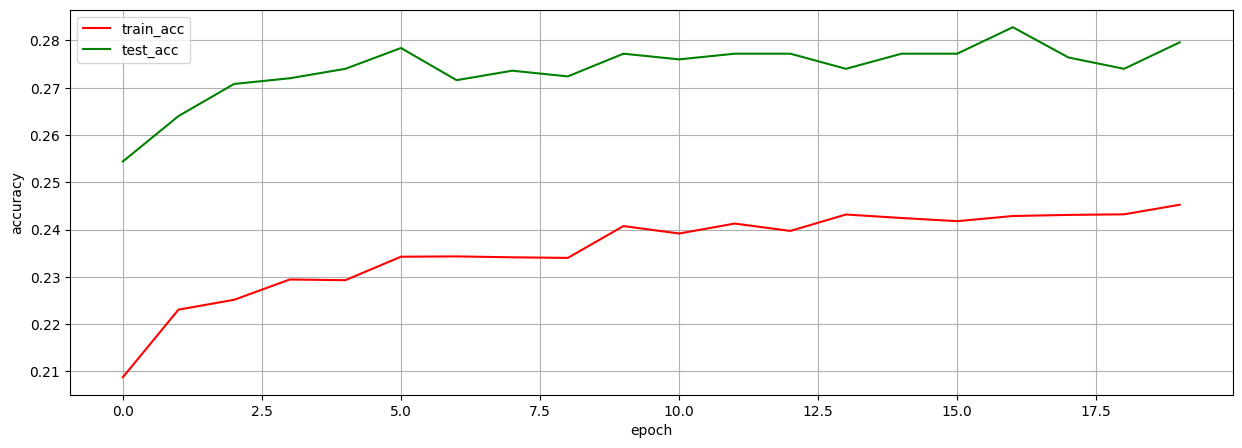

In [52]:
plot_accuracy(train_acc, test_acc)